### YAMNet Transfer Learning for Environmental Sound Classification
- Source: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio
- This deep learning classifier recognizes 521 types of sounds
- Transfer learning on an additional data set: https://blog.tensorflow.org/2021/03/transfer-learning-for-audio-data-with-yamnet.html
- Another site: https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

### Transfer Learning based on trained YAMNet
- The new data set contains two types of sound files, one with AM Modulation from Wind Turbine and the other without

In [1]:
import sys

oneDrive_root={}
oneDrive_root[1]="C:\\Users\\Chihyang\OneDrive for Business\\"
oneDrive_root[2]="C:\\Users\\Chihyang\OneDrive for Business\\"
oneDrive_root[3]="C:\\Users\\tsaic\\OneDrive - State University of New York at New Paltz\\"  # laptop

site=3   # the short or long business OneDrive directory name
lib_dir=oneDrive_root[site]+'\\Prudentia\\Tsaipy'
# append additional library path for this study
sys.path.append(lib_dir)

In [2]:
### import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import os
import glob

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

2024-03-25 20:10:54.646325: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 20:10:54.708795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 20:10:55.265351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import sys
current_dir = %pwd
lib_dir=current_dir+'//audio_lib'
sys.path.append(lib_dir)

from audio_lib import yamnet as ym

In [5]:
## test tenforflow gpu
tf.config.list_physical_devices('GPU')

2024-03-25 20:10:56.105982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.179221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.179263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the H1 clean sample id's from MongoDB

In [6]:
## Read in a text file
with open('H1_S843.txt', 'r') as file:
    ## read each line in the file as an element in a list
    S843 = file.readlines()
    ## remove the newline character from each string
    S843 = [line.strip() for line in S843]

print(len(S843))
print(S843)


843
['H1_1006', 'H1_0101', 'H1_1010', 'H1_1011', 'H1_1013', 'H1_1015', 'H1_1016', 'H1_1023', 'H1_1027', 'H1_1028', 'H1_1032', 'H1_1035', 'H1_1036', 'H1_1037', 'H1_1038', 'H1_1039', 'H1_1043', 'H1_1045', 'H1_0105', 'H1_1050', 'H1_1051', 'H1_1053', 'H1_1058', 'H1_1060', 'H1_1063', 'H1_1064', 'H1_1065', 'H1_1072', 'H1_1074', 'H1_0108', 'H1_1080', 'H1_1083', 'H1_1087', 'H1_0109', 'H1_1090', 'H1_1093', 'H1_0110', 'H1_1100', 'H1_1105', 'H1_1106', 'H1_1107', 'H1_1112', 'H1_1115', 'H1_1116', 'H1_1117', 'H1_1120', 'H1_1122', 'H1_1126', 'H1_1129', 'H1_1131', 'H1_1132', 'H1_1133', 'H1_1135', 'H1_1141', 'H1_1143', 'H1_1144', 'H1_1146', 'H1_1148', 'H1_1150', 'H1_1152', 'H1_1155', 'H1_1159', 'H1_1161', 'H1_1169', 'H1_1177', 'H1_1181', 'H1_1185', 'H1_1186', 'H1_1188', 'H1_1197', 'H1_1199', 'H1_0012', 'H1_1210', 'H1_1221', 'H1_1223', 'H1_1224', 'H1_1229', 'H1_0123', 'H1_1232', 'H1_1239', 'H1_1240', 'H1_1241', 'H1_1243', 'H1_1247', 'H1_1248', 'H1_0125', 'H1_1254', 'H1_1260', 'H1_1261', 'H1_1268', 'H1_1

In [7]:
dir_wav = './/wav_files//'  # Directory where the audio files are stored


### Create a dataframe to hold the training/validation/test file names and target (class) value
#### Clean samples are marked with target = 1 and contaminated damples are marked as target=0
- df_cls["filename"]: contains the wav file name including the path
- df_cls["target"]: the digital format, (0,1), of the class variable

In [8]:
H1_S3000 = ['H1_'+str(i).zfill(4) for i in range(1,3001)]
File_names =  [dir_wav+s+'.wav' for s in H1_S3000]
# create a dataframe using H1_S3000 as the index, and a column class with value 0
df_cls = pd.DataFrame({'filename':File_names,'target': 0}, index=H1_S3000)
print(df_cls.shape)
print(df_cls.head(3))

## Set the class for each of the S843 to 1
df_cls.loc[S843, 'target'] = 1
df_cls['target'].value_counts()

(3000, 2)
                          filename  target
H1_0001  .//wav_files//H1_0001.wav       0
H1_0002  .//wav_files//H1_0002.wav       0
H1_0003  .//wav_files//H1_0003.wav       0


0    2157
1     843
Name: target, dtype: int64

### Creating an n-fold data separation from collected cases (files) with a binary class variable
- Inputs: (1) a dataframe indexed by case file names (not including the path) with a __binary target variable__ column with a __0/1 value__ (2) Number of folds desired
- Output: A dataframe with an additional column indicating the fold each file (row) is assigned to.
- Key property: In each fold, the ratio between the two binary classes is maintained at the same level as the overall ratio.
- This function is designed to be used in conjunction with the yamnet.py script, which is used to extract features from audio files.

##### Purpose of this function
- When developing a training, validating, and testing process on a machine learning or deep learning algorithm, one can easily assigned certain fold(s) to serve as the training, validating, and testing sets.
- As the binary class ratio is maintained, we don't need to worry about any particular fold having a skewed ratio that might affect the result.

#### A note
- This function does not actually work on the cases (files).  Instead, it works on a summary table about the file.
- The dataframe is indexed by the file name without the path and other properties included in the columns include (1) full file name with path, and (2) any other file specific properties we want to keep, and (3) the returned dataframe has an additional column recording the __fold id__ each case is assigned to.

In [9]:
df_cls=ym.n_fold_data_separation(df_cls, 5, 'target', 42)
print(df_cls['fold'].value_counts())

Number of cases in:
  the negative class: 2157
 the positive class: 843
Before switch the first and last fold
Fold 0: Negative cases: 432, Positive cases: 169
Fold 1: Negative cases: 432, Positive cases: 169
Fold 2: Negative cases: 431, Positive cases: 169
Fold 3: Negative cases: 431, Positive cases: 168
Fold 4: Negative cases: 431, Positive cases: 168
Fold 0: Negative cases: 432, positive cases: 169
Fold 1: Negative cases: 432, positive cases: 169
Fold 2: Negative cases: 431, positive cases: 169
Fold 3: Negative cases: 431, positive cases: 168
Fold 4: Negative cases: 431, positive cases: 168
0    601
1    601
2    600
3    599
4    599
Name: fold, dtype: int64
Positive case in each fold(0): 169 
Positive case in each fold(1): 169 
Positive case in each fold(2): 169 
Positive case in each fold(3): 168 
Positive case in each fold(4): 168 
First five rows of the created DataFrame:
                           filename  target  fold
H1_0001  .//wav_files//H1_0001.wav       0     2
H1_0002  

### Load the trained YAMNet model

In [10]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])
ds_cls_names = pd.Series(class_names, name='target')

print(f"#### There are {len(class_names)} classes, some of which are:\n")
for name in class_names[:20]:
  print(name)
print('.....')

2024-03-25 20:10:56.395526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.395616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.395633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.992990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 20:10:56.993106: I tensorflow/compile

#### There are 521 classes, some of which are:

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
.....


### Test on one file using the original YAMNet classes

2024-03-25 20:10:59.078199: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2024-03-25 20:10:59.078402: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


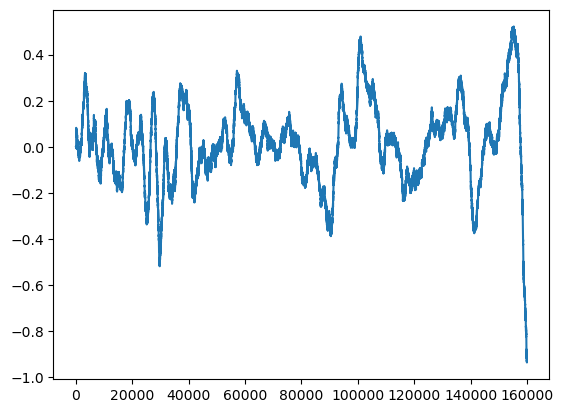

In [12]:
testing_wav_data = ym.load_wav_16k_mono(df_cls.loc['H1_0007', 'filename'])

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [13]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)  # 521 scores, one for each class
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The class id is: {top_class}')
print(f'The class sound is: {inferred_class}')

2024-03-25 20:10:59.366260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]
2024-03-25 20:11:00.229179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-25 20:11:00.344420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


The class id is: 514
The class sound is: White noise
score has the shape (n_frames, n_classes): (20, 521)
score has the shape (n_frames, n_classes): 521
The embeddings shape: (20, 1024)


(1008, 64)


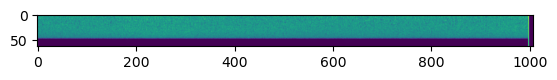

In [14]:
import matplotlib.pyplot as plt
## plot the log mel spectrogram
## each frame contains a 0.025s audio clip with a 0.01s hop
# Assuming the spectrogram is stored in the variable 'spectrogram'
print(spectrogram.shape)
# transpose the spectrogram to have the time axis in the x-axis
spectrogram = tf.transpose(spectrogram)
plt.imshow(spectrogram)
plt.show()


### Training the transferred learning model with a new class variable

In [15]:
### New classes added to the YAMNet model
my_classes = ['Non-Clean', 'Clean']

In [17]:
filenames = df_cls['filename']
targets = df_cls['target']
folds = df_cls['fold']

## convert the dataframe to tensorflow dataset
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

In [18]:
main_ds = main_ds.map(ym.load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
## This function remains in the main code because yamnet_model is only visible in the main code
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  #print("Number of embeddings: ",num_embeddings.numpy())
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

In [20]:
## Extract embedding from the YAMNet model
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

2024-03-25 20:11:01.391709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float
	 [[{{node args_0}}]]


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Create the training, validating, and testing tensor_slices


In [21]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold <=3)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)


# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
#  find the shape of train_ds
for x, y in train_ds.take(1):
  print(f'Features shape: {x.shape}')
  print(f'Labels shape: {y.shape}')

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
print("Training dataset size: ",train_ds_size)

2024-03-25 20:11:01.543932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_106' with dtype float and shape [512]
	 [[{{node Placeholder/_106}}]]
2024-03-25 20:11:01.545506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_129' with dtype resource
	 [[{{node Placeholder/_129}}]]


Features shape: (32, 1024)
Labels shape: (32,)
Training dataset size:  -2


2024-03-25 20:11:03.012484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-25 20:11:03.012844: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 303,682
Trainable params: 303,682
Non-trainable params: 0
_________________________________________________________________


In [27]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [28]:
history = my_model.fit(train_ds,
                       epochs=30,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/30


2024-03-25 20:11:03.134147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype resource
	 [[{{node Placeholder/_33}}]]
2024-03-25 20:11:03.135623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]
2024-03-25 20:11:04.856914: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2ae61a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 20:11:04.856947: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capabilit

   1498/Unknown - 86s 56ms/step - loss: 0.4093 - accuracy: 0.7825

2024-03-25 20:12:29.372940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_35' with dtype resource
	 [[{{node Placeholder/_35}}]]
2024-03-25 20:12:29.374610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_124' with dtype resource
	 [[{{node Placeholder/_124}}]]


1501/1501 [==============================] - 90s 58ms/step - loss: 0.4092 - accuracy: 0.7825 - val_loss: 0.5058 - val_accuracy: 0.7487
Epoch 2/30
1501/1501 [==============================] - 6s 4ms/step - loss: 0.3944 - accuracy: 0.7902 - val_loss: 0.5256 - val_accuracy: 0.7451
Epoch 3/30
1501/1501 [==============================] - 5s 4ms/step - loss: 0.3899 - accuracy: 0.7940 - val_loss: 0.6158 - val_accuracy: 0.7513
Epoch 4/30
1501/1501 [==============================] - 5s 4ms/step - loss: 0.3832 - accuracy: 0.7963 - val_loss: 0.5141 - val_accuracy: 0.7514
Epoch 5/30
1501/1501 [==============================] - 5s 3ms/step - loss: 0.3753 - accuracy: 0.8026 - val_loss: 0.6240 - val_accuracy: 0.7564
Epoch 6/30
1501/1501 [==============================] - 5s 3ms/step - loss: 0.3738 - accuracy: 0.8033 - val_loss: 0.6721 - val_accuracy: 0.7660
Epoch 7/30
1501/1501 [==============================] - 5s 3ms/step - loss: 0.3737 - accuracy: 0.8047 - val_loss: 0.6004 - val_accuracy: 0.7645
E

In [29]:
## Run the trained transfer learning model on the test dataset (test_ds contains embeddings and labels of test samples)
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

     16/Unknown - 0s 7ms/step - loss: 0.9751 - accuracy: 0.6484 

2024-03-25 20:15:09.555014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype resource
	 [[{{node Placeholder/_19}}]]
2024-03-25 20:15:09.556435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_98' with dtype resource
	 [[{{node Placeholder/_98}}]]


375/375 [==============================] - 3s 9ms/step - loss: 0.6841 - accuracy: 0.7657
Loss:  0.6841245889663696
Accuracy:  0.7656928300857544


In [31]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [32]:
import os
saved_model_path = './/trained_models//Clean_trained_H1_yamnet//'
## remove all directories in the saved_model_path

folder_path = saved_model_path

# Delete all files within the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)

# Delete all subfolders within the folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
        os.rmdir(subfolder_path)


In [33]:
## save the trained model
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

2024-03-25 20:15:13.394652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int32 and shape [?]
	 [[{{node inputs_3}}]]
2024-03-25 20:15:13.396601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2024-03-25 20:15:13.396689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [3]
	 [[{{node inputs_1}}]]
2024-03-25 20:15

2024-03-25 20:15:15.087163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]
2024-03-25 20:15:15.116750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?]
	 [[{{node Placeholder}}]]
2024-03-25 20:15:15.222954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'waveform' with dtype float and shape [?]
	 [[{{node waveform}}]]
2024-03-25

INFO:tensorflow:Assets written to: .//trained_models//Clean_trained_H1_yamnet//assets


INFO:tensorflow:Assets written to: .//trained_models//Clean_trained_H1_yamnet//assets


## Reload the trained model

In [34]:
## Run this block if not retraining the model
testing_wav_data = ym.load_wav_16k_mono(df_cls.loc['H1_1011', 'filename'])
my_classes = ['Non-Clean', 'Clean']
## load the saved trained model
reloaded_model = tf.saved_model.load(saved_model_path)

2024-03-25 20:15:18.639741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int32 and shape [?]
	 [[{{node inputs_3}}]]
2024-03-25 20:15:18.645023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_1' with dtype int32 and shape [1,2]
	 [[{{node inputs_1}}]]
2024-03-25 20:15:18.745920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [1]
	 [[{{node inputs}}]]
2024-03-25 20:15:1

In [35]:
## Test the reloaded model on one audio file
## Input is the raw data (wav file) instead of the embedding as the transfer learning model has an embedding layer
reloaded_results = reloaded_model(testing_wav_data)
## get embedding from the reloaded model
reloaded_results = reloaded_results.numpy()
print(reloaded_results.shape)

print(f'The result has shape: {reloaded_results}')
Clean_or_not = my_classes[tf.math.argmax(reloaded_results)]
print(f"This sample is classified as: {Clean_or_not}")


(2,)
The result has shape: [-0.89454174  0.28468233]
This sample is classified as: Clean


2024-03-25 20:15:21.485278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [160000]
	 [[{{node inputs}}]]


0    601
1    601
2    600
3    599
4    599
Name: fold, dtype: int64
Confusion Matrix:
 [[396  35]
 [ 65 103]]
Total number of cases predicted = 599;  Number of correct predictions = 499
Accuracy rate:  0.8330550918196995
Precision:  0.7463768115942029
Recall:  0.6130952380952381
F1 score:  0.673202614379085


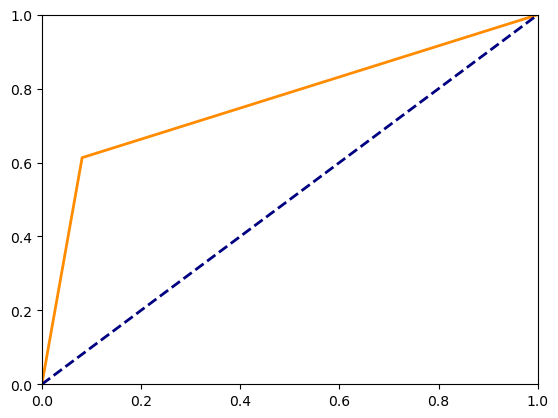

In [41]:
df_ts, n_correct, accuracy=ym.classify_fold_files(reloaded_model,df_cls, my_classes, fold_id=4)

0    601
1    601
2    600
3    599
4    599
Name: fold, dtype: int64
Confusion Matrix:
 [[1978  179]
 [ 253  590]]
Total number of cases predicted = 3000;  Number of correct predictions = 2568
Accuracy rate:  0.856
Precision:  0.7672301690507152
Recall:  0.6998813760379596
F1 score:  0.7320099255583126


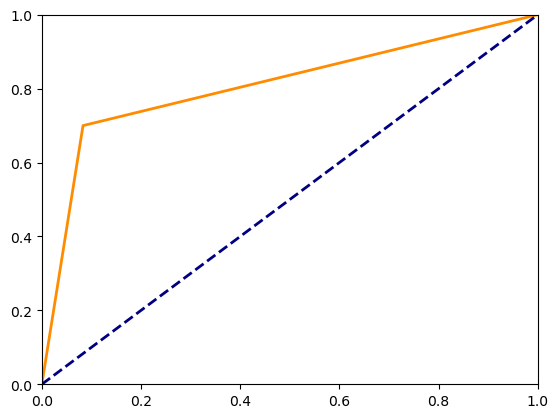

In [42]:
df_ts, n_correct, accuracy=ym.classify_fold_files(reloaded_model,df_cls, my_classes, fold_id=None)

In [52]:
H2_S3000 = ['H2_'+str(i).zfill(4) for i in range(1,3001)]
File_names =  [dir_wav+s+'.wav' for s in H2_S3000]
# create a dataframe using H1_S3000 as the index, and a column class with value 0
df_cls = pd.DataFrame({'filename':File_names,'predict': None,'pred_label':None}, index=H2_S3000)
print(df_cls.shape)
print(df_cls.head(3))

df_H2_class=ym.classify_batch_files(reloaded_model, df_cls, my_classes)

(3000, 3)
                          filename predict pred_label
H2_0001  .//wav_files//H2_0001.wav    None       None
H2_0002  .//wav_files//H2_0002.wav    None       None
H2_0003  .//wav_files//H2_0003.wav    None       None
Size of each class:  Non-Clean    2410
Clean         590
Name: pred_label, dtype: int64
